In [6]:
#load libraries
library(tidyverse)
library(dplyr)
library(lubridate)
library(ggplot2)

In [7]:
#read in data
players <- read_csv("project_data/players.csv")
sessions <- read_csv("project_data/sessions.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [8]:
# Create a session_length column in minutes
sessions <- sessions |>
  mutate(
    start_time = ymd_hms(start_time),
    end_time = ymd_hms(end_time),
    session_length = as.numeric(difftime(end_time, start_time, units = "mins"))
  )
# Summarize for each player
player_activity_summary <- sessions |>
  group_by(hashedEmail) |>
  summarise(
    total_sessions = n(),
    total_playtime = sum(session_length, na.rm = TRUE),
    avg_session_length = mean(session_length, na.rm = TRUE)
  )

# Preview
player_activity_summary |> slice_head(n = 5)

hashedEmail,total_sessions,total_playtime,avg_session_length
<chr>,<int>,<dbl>,<dbl>
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,2,5.255778e+05,2.627889e+05
060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,1,5.000000e-01,5.000000e-01
0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,1,1.833333e-01,1.833333e-01
0d4d71be33e2bc7266ee4983002bd930f69d304288a8663529c875f40f1750f3,13,6.966667e+00,5.358974e-01
0d70dd9cac34d646c810b1846fe6a85b9e288a76f5dcab9c1ff1a0e7ca200b3a,2,1.166667e+00,5.833333e-01


In [9]:
player_profiles <- players |>
  left_join(player_activity_summary, by = "hashedEmail")

# Preview
player_profiles |> 
    slice_head(n = 5)

experience,subscribe,hashedEmail,played_hours,name,gender,Age,total_sessions,total_playtime,avg_session_length
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,27,-1.310697e+07,-4.854432e+05
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,3,4.250000e+00,1.416667e+00
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,1,8.333333e-02,8.333333e-02
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,1,8.333333e-01,8.333333e-01
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,1,1.500000e-01,1.500000e-01


In [10]:
players_with_activity <- players |>
  left_join(player_summary, by = "hashedEmail")

# Display the first 5 rows to check the joined data
players_with_activity |>
  slice_head(n = 5)

ERROR: Error in eval(expr, envir, enclos): object 'player_summary' not found


In [11]:
activity_features <- player_profiles |>
  select(total_sessions, total_playtime, avg_session_length) |>
  drop_na()

activity_features_scaled <- as_tibble(scale(activity_features))

activity_features_scaled |> 
    slice_head(n = 5)

total_sessions,total_playtime,avg_session_length
<dbl>,<dbl>,<dbl>
0.3561844,-7.220635764,-6.59581791
-0.2245511,-0.002835715,-0.09525277
-0.2729457,-0.002838010,-0.09527062
-0.2729457,-0.002837597,-0.09526058
-0.2729457,-0.002837973,-0.09526973


In [12]:
# Set a seed for reproducibility so clustering results are consistent each time the code runs
set.seed(123)
# Run k-means clustering with 3 clusters (as an example)
# Only cluster on the numeric, scaled features
kmeans_model <- kmeans(activity_features_scaled, centers = 3)

# Add the cluster assignments as a new column in the scaled feature table
activity_features_scaled <- activity_features_scaled |>
  mutate(cluster = as.factor(kmeans_model$cluster))

# Show the first 5 rows to preview cluster assignments
activity_features_scaled |> slice_head(n = 5)

total_sessions,total_playtime,avg_session_length,cluster
<dbl>,<dbl>,<dbl>,<fct>
0.3561844,-7.220635764,-6.59581791,1
-0.2245511,-0.002835715,-0.09525277,1
-0.2729457,-0.002838010,-0.09527062,1
-0.2729457,-0.002837597,-0.09526058,1
-0.2729457,-0.002837973,-0.09526973,1


In [13]:
# For each cluster, calculate the mean of each activity metric and the number of players
cluster_summary <- activity_features_scaled |>
  group_by(cluster) |>
  summarise(
    mean_total_sessions = mean(total_sessions),
    mean_total_playtime = mean(total_playtime),
    mean_avg_session_length = mean(avg_session_length),
    n_players = n()
  )

# Display the summary statistics for all clusters
cluster_summary

cluster,mean_total_sessions,mean_total_playtime,mean_avg_session_length,n_players
<fct>,<dbl>,<dbl>,<dbl>,<int>
1,-0.1494773,-0.1037596,-0.1442089,117
2,-0.2064031,0.4313041,3.9515734,4
3,4.5786155,2.6036656,0.2665359,4


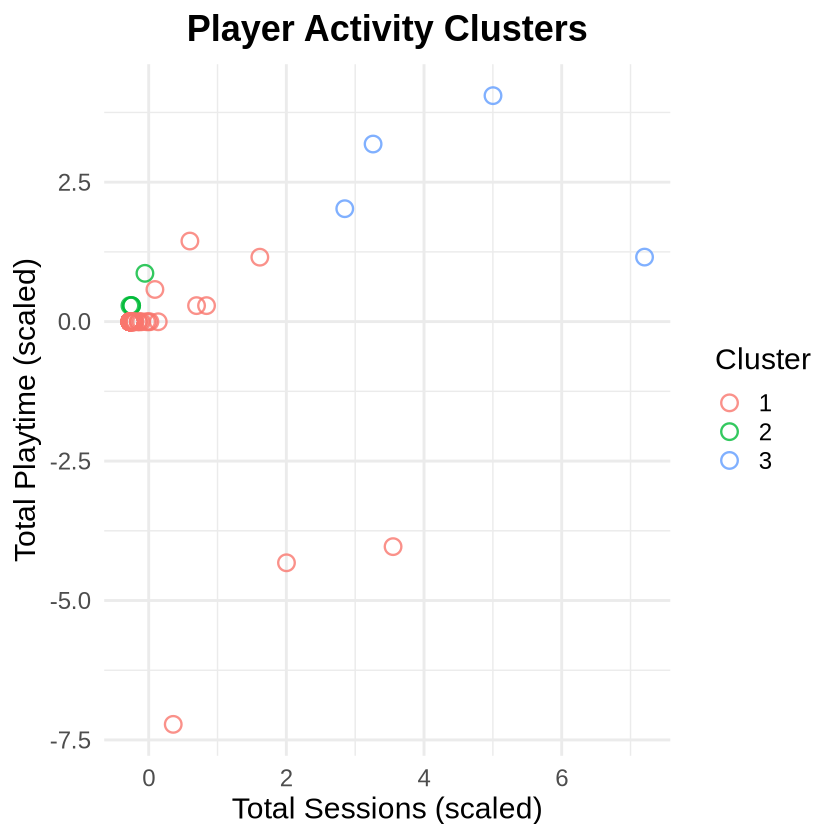

In [14]:
# Create a scatterplot of total_sessions vs. total_playtime, colored by cluster
ggplot(activity_features_scaled, aes(x = total_sessions, y = total_playtime, color = cluster)) +
  geom_point(size = 4, alpha = 0.8, shape = 21, stroke = 1) + # Bigger, outlined points
  labs(
    title = "Player Activity Clusters",
    x = "Total Sessions (scaled)",
    y = "Total Playtime (scaled)",
    color = "Cluster"
  ) +
  theme_minimal(base_size = 18) + 
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"), # Center and bold title
    legend.position = "right"
  )

# A tibble: 6 × 2
      k   wss
  <int> <dbl>
1     1 372. 
2     2 271. 
3     3 191. 
4     4  74.9
5     5  63.7
6     6  51.6


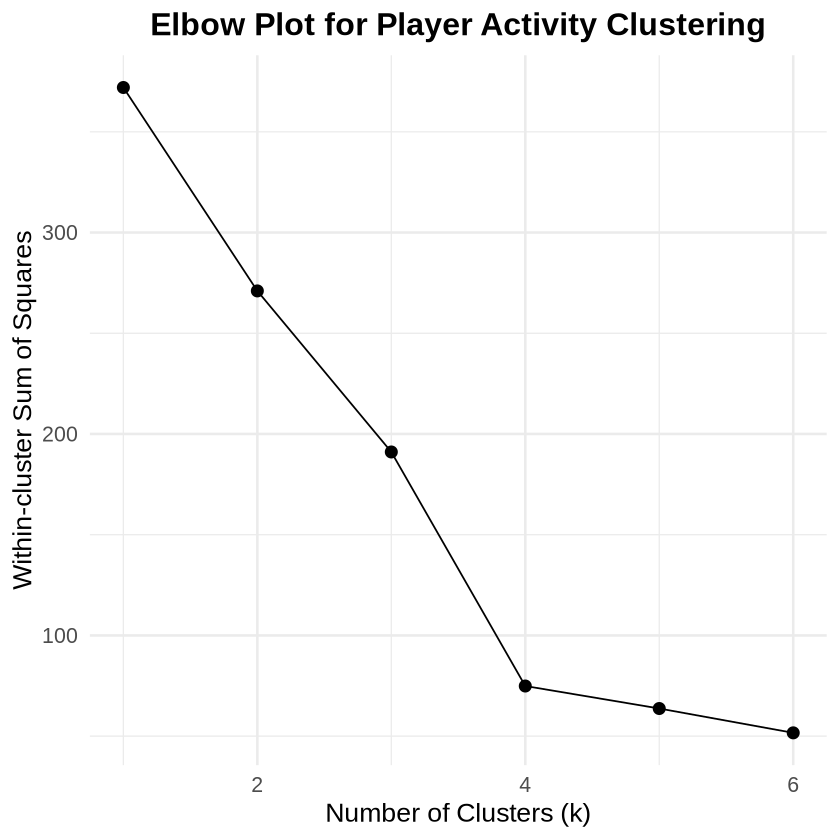

In [15]:
# Calculate total within-cluster sum of squares for k = 1 to 6
wss_activity <- tibble(
  k = 1:6,
  wss = map_dbl(
    1:6,
    ~ kmeans(activity_features_scaled |> select(-cluster), centers = .x)[["tot.withinss"]]
  )
)

# Preview the wss values
wss_activity |> print(n = 6)


# Plot the elbow curve using ggplot (assignment style)
library(ggplot2)
ggplot(wss_activity, aes(x = k, y = wss)) +
  geom_point(size = 3) +
  geom_line() +
  labs(
    title = "Elbow Plot for Player Activity Clustering",
    x = "Number of Clusters (k)",
    y = "Within-cluster Sum of Squares"
  ) +
  theme_minimal(base_size = 16) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold")
  )

In [16]:
# Join the cluster labels back to the unscaled activity features for easier interpretation
activity_features_with_cluster <- activity_features |>
  mutate(cluster = activity_features_scaled |> pull(cluster))

# Summarize mean and count for each cluster
cluster_interpretation <- activity_features_with_cluster |>
  group_by(cluster) |>
  summarise(
    mean_total_sessions = mean(total_sessions),
    mean_total_playtime = mean(total_playtime),
    mean_avg_session_length = mean(avg_session_length),
    n_players = n()
  )

# Display the summary statistics for all clusters
cluster_interpretation

cluster,mean_total_sessions,mean_total_playtime,mean_avg_session_length,n_players
<fct>,<dbl>,<dbl>,<dbl>,<int>
1,6.102564,-183265.9,-3654.492,117
2,3.750000,788368.7,302207.446,4
3,201.500000,4733210.5,27018.818,4


Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `log_value = log10(value + 1)`.
Caused by warning:
! NaNs produced”
Warning message:
“Removed 6 rows containing non-finite outside the scale range (`stat_bin()`).”


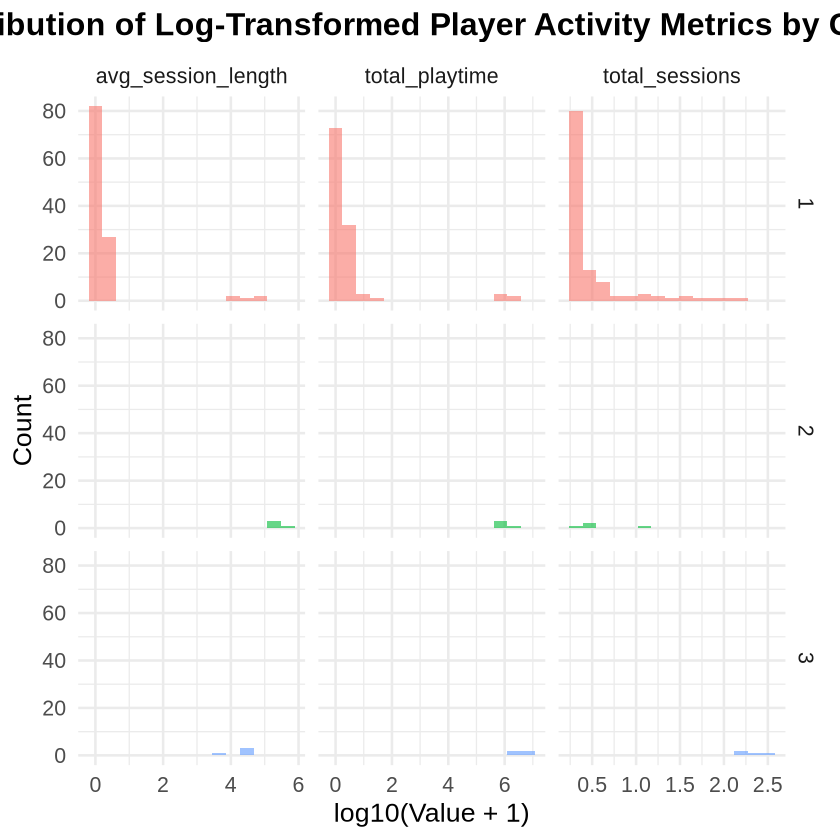

In [19]:
# Convert to long format for easy faceted plotting

activity_long <- activity_features_with_cluster |>
  pivot_longer(
    cols = c(total_sessions, total_playtime, avg_session_length),
    names_to = "metric",
    values_to = "value"
  ) |>
  mutate(log_value = log10(value + 1))

ggplot(activity_long, aes(x = log_value, fill = cluster)) +
  geom_histogram(bins = 15, alpha = 0.6, position = "identity") +
  facet_grid(cluster ~ metric, scales = "free_x") +
  labs(
    title = "Distribution of Log-Transformed Player Activity Metrics by Cluster",
    x = "log10(Value + 1)",
    y = "Count"
  ) +
  theme_minimal(base_size = 16) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),
    legend.position = "none"
  )